![icon](https://github.com/MalloryWittwer/napari-workshop/blob/main/resources/intro-screenshot.png?raw=true)

# n-D Image Data Visualization in Napari
---

This notebook will give you a practical introduction to the [Napari](https://napari.org/) viewer. Napari is a general-purpose N-dimensional image viewer based on `Python`. It is designed for browsing, annotating, and analyzing large multi-dimensional images. By integrating closely with `Python`, napari can be easily coupled to machine learning and image analysis libraries (e.g. `scikit-image`, `scikit-learn`, `TensorFlow`, `PyTorch`) enabling more user-friendly and automated analysis.

### How to use this notebook

You should run the cells in sequence using `Shift + Enter`.

In addition, make sure that
- You are executing this notebook in an environment with `napari`, `sickit-image`, and `scipy` installed.
- You have downloaded the example image `particles_timeseries.tif` from the shared [Drive folder](https://go.epfl.ch/eias2022-data) and placed it in the same folder as this notebook.

If your set-up is correct, you should be able to run the cell below without producing any error.

In [16]:
import napari
import matplotlib.pyplot as plt
import skimage.io as sio

image = sio.imread('particles_timeseries.tif')

print('Loaded image in an array of shape (TZYX): ', image.shape)

print(f'Intensity range: [{image.min()} - {image.max()}]')

Loaded image in an array of shape (TZYX):  (16, 400, 250, 250)
Intensity range: [0 - 65535]


If you run into troubles, don't hesitate to ask for help 🤚🏽.

## For context: standard image visualization in Python
---

### Matplotlib

[Matplotlib]() is the most widely used plotting library for Python. It provides a simple [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function to render an image.

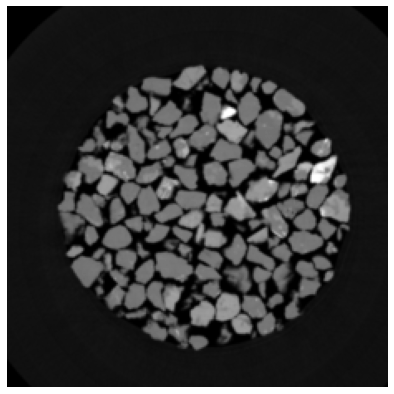

In [9]:
import matplotlib.pyplot as plt

# Pick a single 2D slice from the image at t=0
image_slice = image[-1, 200]

# Display it in a figure
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')
ax.imshow(image_slice, cmap=plt.cm.gray);

### Plotly

[Plotly](https://plotly.com/python/) is an open source graphing library for python. It also offers an [imshow](https://plotly.com/python/imshow/) function for displaying images.

In [ ]:
!pip install plotly

In [10]:
# To install plotly: `pip install plotly`
import plotly.express as px

fig = px.imshow(image_slice, color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

### Ipywidgets

[Jupyter widgets](https://ipywidgets.readthedocs.io/en/latest/) can be used to visualize image stacks by interactively selecting the slice to display.

In [ ]:
!pip install ipywidgets

In [11]:
from ipywidgets import interact
from ipywidgets.widgets import IntSlider, Layout
import matplotlib.pyplot as plt

def interactive_z_figure(z: int=0):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image[-1, z], cmap='gray')
    ax.axis('off')
    fig.canvas.flush_events()

_ = interact(
    interactive_z_figure,
    z=IntSlider(
        value=1,
        min=0, max=image.shape[1]-1,
        step=1,
        description="Select Z",
        continuous_update=True,
        layout=Layout(width='500px')
    )
)

interactive(children=(IntSlider(value=1, description='Select Z', layout=Layout(width='500px'), max=369), Outpu…

## n-D Visualization in Napari
---
In contrast to plotting libraries, Napari is an open source Python-based viewer that supports visualization of large n-dimensional images.

![svg](https://github.com/MalloryWittwer/napari-workshop/blob/main/resources/approaches.svg?raw=true)

### 1. Launching the Viewer

When working from a Jupyter notebook, you have to run this "magic" command before starting napari.

In [5]:
%gui qt

You can run the code below to open the Napari viewer:

In [12]:
import napari

viewer = napari.Viewer();

Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


Note that Napari has appeared in a **seperate window**. This is normal!

**Quick tip:** You can rapidly switch between the Napari viewer and your web browser window using the keyboard shortcut `Alt` + `Tab`.

### 2. Adding an image

You can load image data into the viewer either by drag-and-dropping image files directly onto it, or by programmatically calling `add_image()` from the notebook.

The code below will load our `image` numpy array into the viewer:

In [13]:
viewer.add_image(image);

You can access the layers list and the data in each layer through `viewer.layers`. You can change properties of a layer and the viewer will immediately update. For example, to remove every layer from the viewer, run:

In [8]:
for k in range(len(viewer.layers)):
    viewer.layers.pop(k)

Notice that the viewer is now empty again.

### 3. Image processing

For the demo, we'll focus on the first frame of the time series and try to produce a segmentation of the individual grains.

Let's start by adding an `Image` layer to our viewer:

In [9]:
image_t0 = image[-1]

print('Image at t=0 shape: ', image_t0.shape)

viewer.add_image(image_t0, name='image');

Image at t=0 shape:  (400, 250, 250)


We use [Otsu's method](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html) to threshold the intensity and produce a binary mask separating the foreground from the background. We then add the foreground as a `Labels` layer in Napari.

In [10]:
from skimage.filters import threshold_otsu

foreground = image_t0 >= threshold_otsu(image_t0)

viewer.add_labels(foreground, name='binary');

Next, we compute the Euclidean distance transform of our binary image, which gives an estimate of the distance between each pixel and the closest boundary. Once again, we can use Napari to visualize this intermediate result.

In [11]:
from scipy.ndimage import distance_transform_edt

distance_img = distance_transform_edt(foreground)

viewer.add_image(distance_img, name='distance', colormap='viridis', opacity=0.5);

Then, we detect [local maxima](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html) in the distance image to use them as seed points. In napari, we can display the maxima in a `Points` layer.

In [12]:
import numpy as np
from skimage.feature import peak_local_max
from skimage.morphology import label

peaks_data = peak_local_max(distance_img, indices=False, labels=label(foreground), min_distance=5)
peaks = np.array(np.nonzero(peaks_data)).T

viewer.add_points(peaks, name='peaks', size=4, face_color='red', opacity=0.7);

indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


Finally, we compute a watershed segmentation of the grains using the detected peaks as seed points and show the result in a `Labels` layer in Napari.

In [13]:
from skimage.segmentation import watershed

def peaks_to_markers(peaks):
    """Returns markers from peaks data"""
    peaks_x, peaks_y, peaks_z = peaks.astype('int').T

    seeds = np.zeros(image_t0.shape, dtype=bool)
    seeds[(peaks_x, peaks_y, peaks_z)] = 1

    # Label the marker points
    markers = label(seeds)
    
    return markers


# We do some minor tweaking to get the peaks data into the right format for watereshed
markers = peaks_to_markers(peaks)

# Watershed segmentation
particle_labels = watershed(-distance_img, markers, mask=foreground)

# Display the segmentation in a `Labels` layer
viewer.add_labels(particle_labels, name='segmentation');

You could spend time perfecting this segmentation by using more operations (e.g. denoising, background subtraction...), different methods, or optimizing algorithmic parameters.The point is that, with Napari, you can always visualize the intermediate steps of the image processing, and thus control them more easily. You can also use Napari to interactively edit the data in the layers, for example to correct segmentation results, or add / remove points, or shapes, to create annotations. See an example [here](https://napari.org/tutorials/annotation/annotate_points.html).

### 4. Plugins

Napari offers a range of community-developed plugins to extend the capabilities of the viewer. You can browse existing plugins on the [Napari Hub](https://www.napari-hub.org/).

An example of Plugin is [napari-skimage-regionprops](https://github.com/haesleinhuepf/napari-skimage-regionprops), which lets you measure properties of labeled objects.

To install that plugin, open the “Plugins” menu from within the napari application and select “Install/Uninstall Package(s)...”.

In [14]:
# To run this cell, you should first install the plugin napari-skimage-regionprops from the Plugins menu in Napari
from skimage.measure import regionprops_table
from napari_skimage_regionprops import visualize_measurement_on_labels

# Compute region properties
statistics = regionprops_table(particle_labels, properties=['area'])

# Add the statistics as properties of the Labels layer
label_image = viewer.layers['segmentation']
label_image.properties = statistics

# Compute the parametric image
parametric_image = visualize_measurement_on_labels(label_image, 'area')

# Display the parametric image
viewer.add_image(parametric_image, name="volume", colormap='jet');

### 5. Multichannel images

Different channels in an image can be loaded into separate `Image` layers and be viewed using different lookup tables.

In [15]:
from skimage.data import cells3d

multichannel_image = cells3d()

print('Shape of the multichannel image (ZCXY): ', multichannel_image.shape)

# Clean-up the viewer
for k in range(len(viewer.layers)):
    viewer.layers.pop(0)

# Specify `channel_axis` when loading a multi-channel image
viewer.add_image(multichannel_image, channel_axis=1, name=['membrane', 'nuclei']);

Shape of the multichannel image (ZCXY):  (60, 2, 256, 256)


### 6. Adding interactivity with custom GUI elements

This is an advanced topic, but once you get the hang of Napari, you can start creating your own GUI widgets to control the viewer interactively. For example, you could design a `Slider` widget to control binary thresholding.

Learn more about creating custom widgets in Napari and magicgui in the official [documentation](https://napari.org/guides/magicgui.html).

In [16]:
from napari.types import ImageData, LabelsData
from magicgui import magicgui
from skimage.exposure import rescale_intensity

@magicgui(auto_call=True,
          threshold={"widget_type": "FloatSlider", "max": 1, "min": 0},
          layout='vertical')
def binary_thresold(layer: ImageData, threshold: float=0.5) -> LabelsData:
    """Applies a binary threshold to the image."""
    if layer is not None:
        layer_rescaled = rescale_intensity(layer, out_range=(0, 1))
        return (layer_rescaled > threshold).astype('int')

# Add the GUI element as a dock widget in the viewer
viewer.window.add_dock_widget(binary_thresold, area='right', name="Threshold selection");

## 🎓 Learning more
---
Napari supports seven different layer types, each corresponding to a different data type, visualization, and interactivity. You can learn more about the available layer types [here](https://napari.org/howtos/layers/index.html).
![layers](https://github.com/MalloryWittwer/napari-workshop/blob/main/resources/layers.svg?raw=true)

To dive deeper into Napari, you can check:

- [napari.org](https://napari.org/)
- [napari.org documentation](https://napari.org/docs/)
- [napari.org tutorials](https://napari.org/tutorials/)
- [napari's Github repo](https://github.com/napari/napari)

If you ever get stuck with Napari, a good place where to find help is the Image SC forum:
- [Image.sc forum](https://forum.image.sc/tag/napari)

## Practice session
---

![practice](https://github.com/MalloryWittwer/napari-workshop/blob/main/resources/practice_session.png?raw=true)